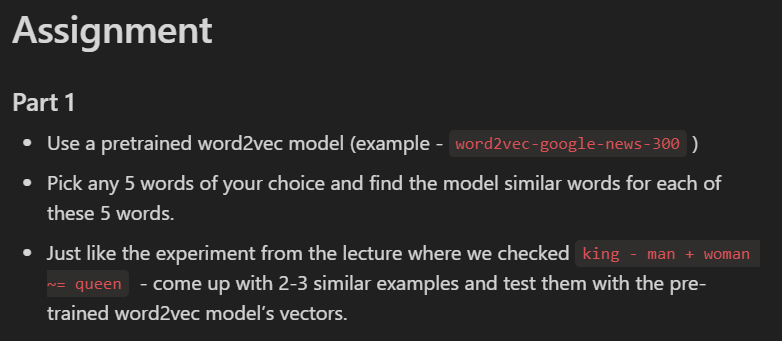

In [7]:
import gensim.downloader as api
import warnings

# Suppress deprecation warnings for cleaner output
warnings.filterwarnings("ignore", category=DeprecationWarning)

def explore_word2vec_model(model_name="word2vec-google-news-300"):
    """
    Loads a pre-trained Word2Vec model, finds similar words,
    and tests word analogies.
    """
    try:
        print(f"Loading the '{model_name}' model... (This may take a while)")
        # Load the pre-trained model from gensim's API
        wv = api.load(model_name)
        print("Model loaded successfully. 🚀\n")
    except Exception as e:
        print(f"Failed to load model. Error: {e}")
        print("Please ensure you have an internet connection.")
        return

    # --- Task 1: Find similar words for 5 chosen words ---
    print("--- 1. Finding Most Similar Words ---")
    words_to_check = ['computer', 'india', 'music', 'happy', 'running']
    
    for word in words_to_check:
        try:
            similar_words = wv.most_similar(word, topn=5)
            print(f"\nWords most similar to '{word}':")
            for sim_word, score in similar_words:
                print(f"  - {sim_word:<20} (Similarity: {score:.4f})")
        except KeyError:
            print(f"\nWord '{word}' not found in the vocabulary.")

    # --- Task 2: Come up with 2-3 similar examples and test them ---
    print("\n\n--- 2. Testing Word Analogies ---")

    # Analogy 1: Paris is to France as Berlin is to ??? (Expected: Germany)
    # Analogy: vector('France') - vector('Paris') + vector('Berlin') ~= vector('Germany')
    try:
        print("\nAnalogy 1: Paris - France + Germany ≈ ???")
        result1 = wv.most_similar(positive=['Germany', 'Paris'], negative=['France'], topn=3)
        print("Model predicts:")
        for res_word, score in result1:
            print(f"  - {res_word:<20} (Score: {score:.4f})")
    except KeyError as e:
        print(f"A word in the analogy was not found in the vocabulary: {e}")


    # Analogy 2: Microsoft is to Windows as Google is to ??? (Expected: Android/Search)
    # Analogy: vector('Windows') - vector('Microsoft') + vector('Google') ~= vector('Android')
    try:
        print("\nAnalogy 2: Windows - Microsoft + Google ≈ ???")
        result2 = wv.most_similar(positive=['Google', 'Windows'], negative=['Microsoft'], topn=3)
        print("Model predicts:")
        for res_word, score in result2:
            print(f"  - {res_word:<20} (Score: {score:.4f})")
    except KeyError as e:
        print(f"A word in the analogy was not found in the vocabulary: {e}")

# --- Execute the function ---
if __name__ == "__main__":
    explore_word2vec_model()

Loading the 'word2vec-google-news-300' model... (This may take a while)
[==================================================] 100.0% 1662.8/1662.8MB downloaded
Model loaded successfully. 🚀

--- 1. Finding Most Similar Words ---

Words most similar to 'computer':
  - computers            (Similarity: 0.7979)
  - laptop               (Similarity: 0.6640)
  - laptop_computer      (Similarity: 0.6549)
  - Computer             (Similarity: 0.6473)
  - com_puter            (Similarity: 0.6082)

Words most similar to 'india':
  - indian               (Similarity: 0.6967)
  - usa                  (Similarity: 0.6836)
  - pakistan             (Similarity: 0.6815)
  - chennai              (Similarity: 0.6676)
  - america              (Similarity: 0.6589)

Words most similar to 'music':
  - classical_music      (Similarity: 0.7198)
  - jazz                 (Similarity: 0.6835)
  - Music                (Similarity: 0.6596)
  - Without_Donny_Kirshner (Similarity: 0.6416)
  - songs                (Si

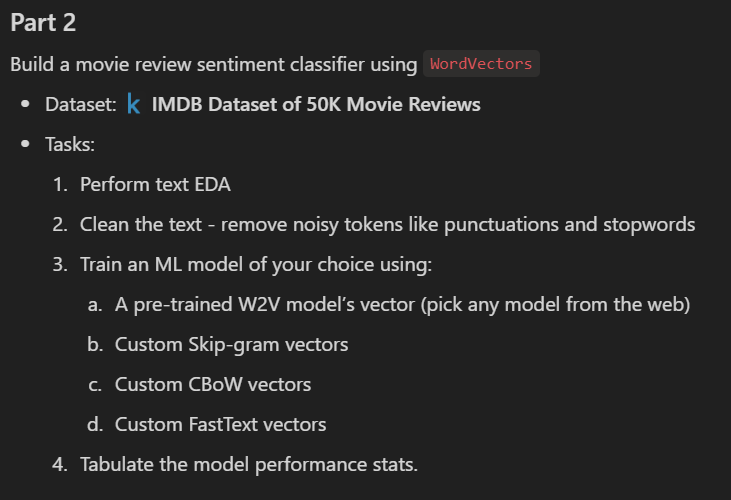

In [8]:
import pandas as pd
import numpy as np
import re
import warnings
from tqdm import tqdm

# Gensim for text processing and word vectors
import gensim.downloader as api
from gensim.models import Word2Vec, FastText
from gensim.parsing.preprocessing import remove_stopwords

# Scikit-learn for ML model and evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")
tqdm.pandas()

# --- 1. Load Data and Perform EDA ---
print("--- 1. Loading Data and EDA ---")
try:
    df = pd.read_csv('IMDB Dataset.csv')
    print("Dataset loaded successfully.")
    print("\nDataset Info:")
    df.info()
    
    print("\nSentiment Distribution:")
    print(df['sentiment'].value_counts())
    
    print("\nSample Review (Positive):")
    print(df[df.sentiment == 'positive']['review'].iloc[0])
    
except FileNotFoundError:
    print("Error: 'IMDB Dataset.csv' not found. Please make sure the file is in the correct directory.")
    exit()

# --- 2. Text Cleaning and Preprocessing ---
print("\n--- 2. Cleaning and Preprocessing Text ---")

def clean_and_tokenize(text):
    """
    Cleans and tokenizes text by:
    1. Removing HTML tags
    2. Removing punctuation and numbers
    3. Converting to lowercase
    4. Removing stopwords
    5. Splitting into tokens (words)
    """
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    text = remove_stopwords(text)
    # Tokenize
    tokens = text.split()
    return tokens

# Apply the cleaning function to the reviews
# The `progress_apply` shows a progress bar, which is nice for long operations
df['tokens'] = df['review'].progress_apply(clean_and_tokenize)
print("Text cleaning and tokenization complete.")

# Map sentiment labels to binary (0 for negative, 1 for positive)
df['sentiment_binary'] = df['sentiment'].map({'negative': 0, 'positive': 1})

# --- 3. Split Data into Training and Testing Sets ---
print("\n--- 3. Splitting Data (80% Train, 20% Test) ---")
X_train, X_test, y_train, y_test = train_test_split(
    df['tokens'], 
    df['sentiment_binary'], 
    test_size=0.2, 
    random_state=42
)
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# --- 4. Word Embedding and Document Vectorization ---
print("\n--- 4. Generating Document Vectors ---")

def create_document_vector(tokens, wv_model, vector_size):
    """
    Creates a document vector by averaging the word vectors of its tokens.
    """
    vectors = [wv_model[word] for word in tokens if word in wv_model]
    if not vectors:
        # If no words in the document are in the vocabulary, return a zero vector
        return np.zeros(vector_size)
    return np.mean(vectors, axis=0)

# A helper function to run the whole process for a given model
def train_and_evaluate(model_name, wv_model, vector_size):
    print(f"\n----- Processing: {model_name} -----")
    
    # Create document vectors for training and testing data
    print("Creating document vectors...")
    X_train_vecs = np.array([create_document_vector(tokens, wv_model, vector_size) for tokens in tqdm(X_train)])
    X_test_vecs = np.array([create_document_vector(tokens, wv_model, vector_size) for tokens in tqdm(X_test)])

    # Train a Logistic Regression classifier
    print("Training the classifier...")
    lr_classifier = LogisticRegression(max_iter=1000) # Increased max_iter for convergence
    lr_classifier.fit(X_train_vecs, y_train)

    # Make predictions and evaluate
    print("Evaluating the model...")
    y_pred = lr_classifier.predict(X_test_vecs)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Accuracy: {accuracy:.4f}")
    
    # Return performance metrics
    return {
        'Accuracy': accuracy,
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score']
    }

# Dictionary to store performance stats
performance_stats = {}

# --- Strategy 1: Pre-trained Word2Vec (Google News) ---
try:
    print("\nLoading pre-trained 'word2vec-google-news-300' model... (This can take a while and ~1.6GB of RAM)")
    wv_pretrained = api.load("word2vec-google-news-300")
    performance_stats['Pre-trained W2V'] = train_and_evaluate(
        "Pre-trained Word2Vec",
        wv_pretrained,
        vector_size=300
    )
except Exception as e:
    print(f"Could not load pre-trained model. Error: {e}. Skipping.")


# --- Strategy 2: Custom CBOW Model ---
print("\nTraining custom CBOW model...")
# sg=0 for CBOW
custom_cbow_model = Word2Vec(sentences=X_train, sg=0, vector_size=100, window=5, min_count=5, workers=4)
wv_cbow = custom_cbow_model.wv
performance_stats['Custom CBOW'] = train_and_evaluate(
    "Custom CBOW",
    wv_cbow,
    vector_size=100
)

# --- Strategy 3: Custom Skip-gram Model ---
print("\nTraining custom Skip-gram model...")
# sg=1 for Skip-gram
custom_skipgram_model = Word2Vec(sentences=X_train, sg=1, vector_size=100, window=5, min_count=5, workers=4)
wv_skipgram = custom_skipgram_model.wv
performance_stats['Custom Skip-gram'] = train_and_evaluate(
    "Custom Skip-gram",
    wv_skipgram,
    vector_size=100
)

# --- Strategy 4: Custom FastText Model ---
print("\nTraining custom FastText model...")
# sg=1 for Skip-gram architecture in FastText
custom_fasttext_model = FastText(sentences=X_train, sg=1, vector_size=100, window=5, min_count=5, workers=4)
wv_fasttext = custom_fasttext_model.wv
performance_stats['Custom FastText'] = train_and_evaluate(
    "Custom FastText",
    wv_fasttext,
    vector_size=100
)

# --- 5. Tabulate Model Performance ---
print("\n\n--- 5. Final Model Performance Comparison ---")
performance_df = pd.DataFrame(performance_stats).T # Transpose to get models as rows
print(performance_df.round(4))

--- 1. Loading Data and EDA ---
Dataset loaded successfully.

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB

Sentiment Distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Sample Review (Positive):
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is cal

100%|██████████| 50000/50000 [00:03<00:00, 15884.69it/s]


Text cleaning and tokenization complete.

--- 3. Splitting Data (80% Train, 20% Test) ---
Training set size: 40000
Test set size: 10000

--- 4. Generating Document Vectors ---

Loading pre-trained 'word2vec-google-news-300' model... (This can take a while and ~1.6GB of RAM)

----- Processing: Pre-trained Word2Vec -----
Creating document vectors...


100%|██████████| 10000/10000 [00:01<00:00, 5468.44it/s]


Training the classifier...
Evaluating the model...
Accuracy: 0.8459

Training custom CBOW model...

----- Processing: Custom CBOW -----
Creating document vectors...


100%|██████████| 10000/10000 [00:01<00:00, 5944.97it/s]


Training the classifier...
Evaluating the model...
Accuracy: 0.8549

Training custom Skip-gram model...

----- Processing: Custom Skip-gram -----
Creating document vectors...


100%|██████████| 10000/10000 [00:01<00:00, 5769.92it/s]


Training the classifier...
Evaluating the model...
Accuracy: 0.8708

Training custom FastText model...

----- Processing: Custom FastText -----
Creating document vectors...


100%|██████████| 10000/10000 [00:03<00:00, 2597.92it/s]


Training the classifier...
Evaluating the model...
Accuracy: 0.8657


--- 5. Final Model Performance Comparison ---
                  Accuracy  Precision  Recall  F1-Score
Pre-trained W2V     0.8459     0.8459  0.8459    0.8459
Custom CBOW         0.8549     0.8551  0.8549    0.8549
Custom Skip-gram    0.8708     0.8708  0.8708    0.8708
Custom FastText     0.8657     0.8658  0.8657    0.8657
